In [39]:
#IMPORT
import pandas as pd
from bs4 import BeautifulSoup
import requests
import os, shutil
from os import listdir


Functions

In [40]:
# STEP 1: All complexes will be filtered
def filter_complexes():
    # Find and list all complexes in folder that in samae location with this script
    complex_folder = "CovPDB_complexes"
    cwd = os.path.join(os.getcwd(), complex_folder)

    complexes = [f for f in listdir(cwd)]

    # Create new folder in current directory
    name_newfolder = "Resolution_2.5"
    newfolder = os.path.join(os.getcwd(), name_newfolder)

    if not os.path.exists(newfolder):
        os.makedirs(newfolder)
            
    # Seaching and filtering
    count = 0
    all_proteins = [] # Empty list to store protein names as string to use for web scraper

    for protein in complexes: # All index in "complexes" list are also name of the folder and name of the pdb file
        
        protein_folder = os.path.join(cwd, protein) # Directory of parent folder
        pdb_file = os.path.join(protein_folder, f'{protein}.pdb') # Directory of pdb file
        
        with open(pdb_file, 'r') as pdb:
            for line in pdb:
                if 'REMARK   2 RESOLUTION' in line: # Finds resolution line in pdb
                    line = line.split()      
                    try:
                        resolution = float(line[3])     
                        if resolution >= 2.5:
                            destination_folder = os.path.join(newfolder, protein)
                            shutil.copytree(protein_folder, destination_folder)
                            print(f'{protein} with the resolution of {resolution} is copied to {destination_folder} ') 
                            count += 1
                            all_proteins.append(protein)
                        break  
                    except:
                        #print(f'No resolution data of {protein}')
                        pass

    print(f'>>>> {count} folder filtered <<<<')
    print(f'STEP 1 COMPLETED')

    return all_proteins

In [41]:
# STEP 2: CovPDB search, PDB id search term as name of complex as string 
def Find_url(complex_name: str):
    try:
        # URL of the page
        url = 'https://drug-discovery.vm.uni-freiburg.de/covpdb/search/search_type=by_pdb_idsearch_term=' + complex_name

        #  Fetch and parse the HTML content 
        response = requests.get(url)
        html_content = response.content

        soup = BeautifulSoup(html_content, 'html.parser')

        # Find the specific table
        all_tables = soup.find_all('table')
        for table in all_tables:
            thead = table.find('thead')
            if thead and 'Complex(es)' in thead.get_text(): # This is the table we are looking for
                target_table = table
                break

        # Extract URLs from the "SHOW" links
        show_urls = [link['href'] for link in target_table.select('tr.color1 a[href*="complex_card"]')]
        url = "https://drug-discovery.vm.uni-freiburg.de" + show_urls[0] 
        
        print('STEP 2 COMPLETED')
        return url
    except:
        print(f'STEP 2 ERROR: Certain PDB ID cannot be searched on CovPDB database.')
        return 

In [42]:
# STEP 3: Wildcard of the certain complex will be scraped 
def Data_Scraper(url : str):
    try:
        # Fetch and parse the HTML content 
        response = requests.get(url)
        html_content = response.text

        soup = BeautifulSoup(html_content, 'html.parser')

        # Find the specific table
        all_tables = soup.find_all('table')
        for table in all_tables:
            thead = table.find('thead')
            if thead and 'Covalent Mechanism' in thead.get_text(): # This is the table we are looking for

                target_table = table
                break
        
        # Converting as data frame
        rows = table.find_all('tr')
        headers = table.find_all('thead')[1].find_all('td')
        columns = [header.get_text(strip=True) for header in headers]

        data = [] # Empty list to store data

        # Iterate through rows and extract data
        for row in rows:
            cells = row.find_all(['td', 'th'])
            row_data = [cell.get_text(strip=True) for cell in cells]
            data.append(row_data)

        # Create a Pandas DataFrame
        df = pd.DataFrame(data, columns=columns)
        df = df.iloc[[0]]
        df = df.drop(columns='Warhead Structure', errors='ignore')

        print('STEP 3 COMPLETED')
        return df

    except:
        print('STEP 3 ERROR: Data cannot be scraped.')
        return

Run Functions

In [43]:
# STEP 4: Data will be concentrated as dataframe
dataset = pd.DataFrame()
not_collected = []

for protein in all_proteins:
    print(f'{protein} data is collecting')
    try:
        proteindata_url = Find_url(protein)
        data = Data_Scraper(proteindata_url)

        data = data.rename(index={0: protein})

        frames = [dataset,data]
        dataset = pd.concat(frames)

        print(f'Collected\n')
    except:
        not_collected.append(protein)
        print(f'{protein} data cannot be collected')

print(f'PROCESS FINISHED')
print('Not collected proteins: ', not_collected)

1qxa data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

1g93 data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

2hwo data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

3vb6 data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

4kif data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

1hbj data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

6hp8 data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

3i2f data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

4m6y data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

4pjc data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

1ztk data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

4lqm data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

5cz7 data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

5k9i data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
Collected

5d0s data is collecting
STEP 2 COM

In [45]:
dataset.to_csv('Dataset.csv')
dataset.to_excel('Dataset.xlsx')

In [46]:
dataset

,Reaction Name,Residue,Chain ID,SASA,pKa,Warhead Name
1qxa,Disulfide Formation,CYS 223,A,11.09,99.99,Thiosulfonate
1g93,Nucleophilic Acyl Substitution,GLU 317,A,26.91,9.64,Hemiacetal
2hwo,Michael Addition,CYS 345,A,27.65,13.5,Vinyl Carbonyl
3vb6,Nucleophilic Addition to a Triple Bond,CYS 145,A,8.73,13.73,Nitrile
4kif,Hemi(thio)acetalization,CYS 319,A,51.84,12.27,Ketone
...,...,...,...,...,...,...
2ajl,Nucleophilic Addition to a Triple Bond,SER 630,I,19.41,-,Nitrile
1est,Sulfonylation,SER 195,A,25.71,-,Sulfonyl Halide
4pji,Imine Condensation,LYS 43,A,15.53,5.22,Aldehyde
3c9w,Michael Addition,CYS 164,A,17.15,14.47,Vinyl Carbonyl


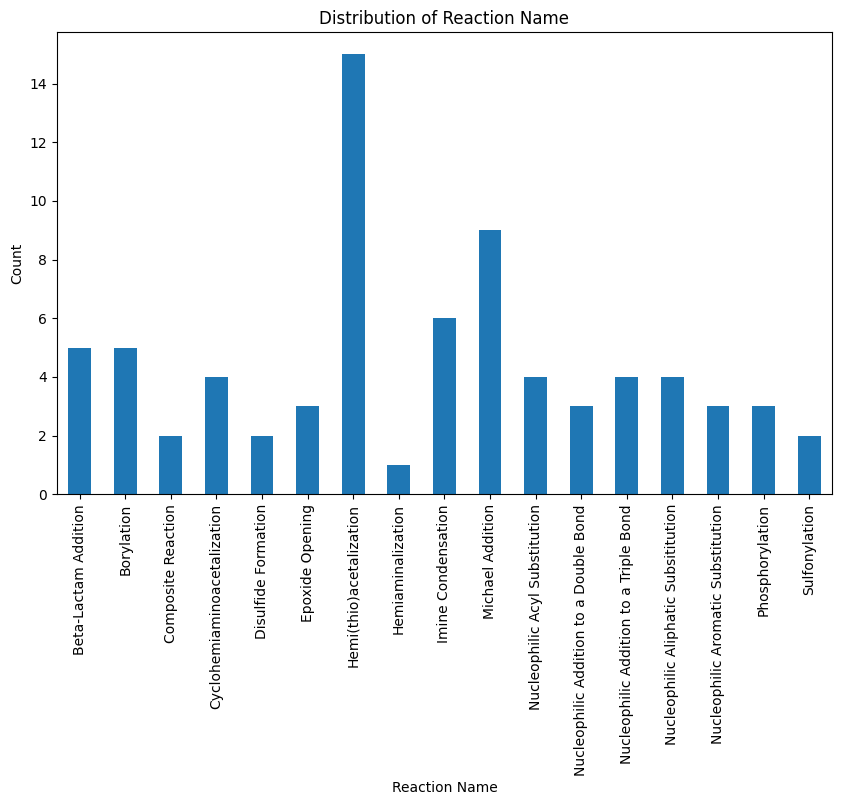

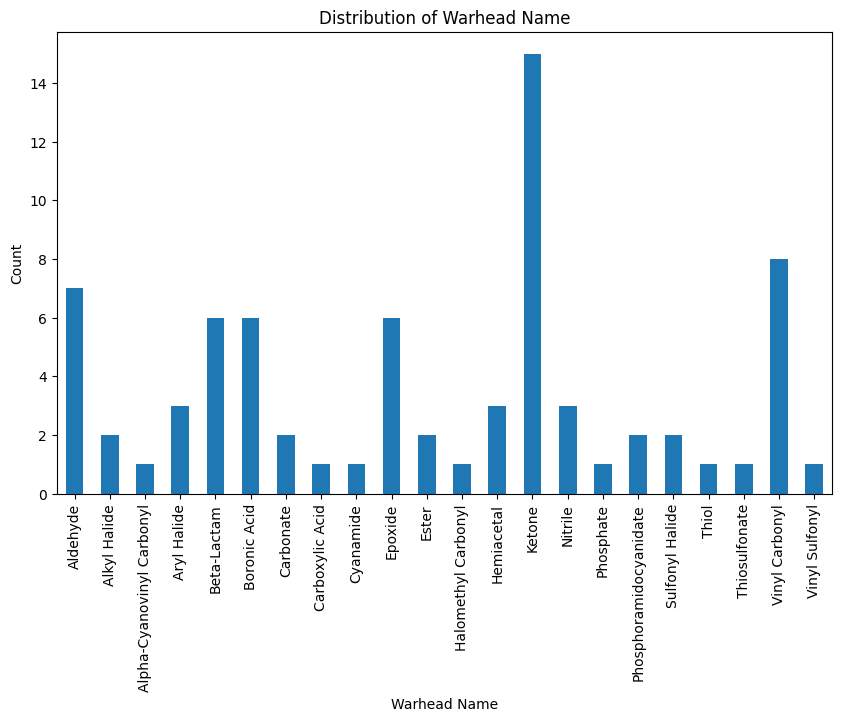

In [49]:
import matplotlib.pyplot as plt

# Function to plot the count of specific values in each column
values_to_plot = ['Reaction Name','Warhead Name']
def plot_value_counts(df, values_to_plot):
    for column in df.columns:
        if column in values_to_plot:
            plt.figure(figsize=(10, 6))
            df[column].value_counts().sort_index().plot(kind='bar')
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Count')
            plt.show()

plot_value_counts(dataset, values_to_plot)